In [1]:
!pip install pyflakes
!pip install tiktoken


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.7 MB/s eta 0:00:00


In [31]:
import sys
import tiktoken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyflakes.api import check as validate_code
from pyflakes.reporter import Reporter as LogHandler
from io import StringIO as MemoryStream
from tqdm import tqdm as progress_bar
from google.colab import drive
drive.mount('/content/drive')

df_alpaca = pd.read_parquet('/content/drive/MyDrive/Thesis/Data/python_code_instructions_18k_alpaca.parquet', engine='pyarrow')
df_alpaca.head()
def check_syntax(code):
    original_stdout, original_stderr = sys.stdout, sys.stderr
    try:
        sys.stdout, sys.stderr = MemoryStream(), MemoryStream()
        return validate_code(code, filename='', reporter=LogHandler(sys.stdout, sys.stderr)) == 0
    finally:
        sys.stdout, sys.stderr = original_stdout, original_stderr

error_indices = [i for i in progress_bar(range(len(df_alpaca))) if not validate_syntax(df_alpaca['output'][i])]
code=df_alpaca
syntactic_error = check_syntax(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 18612/18612 [00:25<00:00, 723.92it/s]


Total tokens: 142996
Avg tokens: 35.66


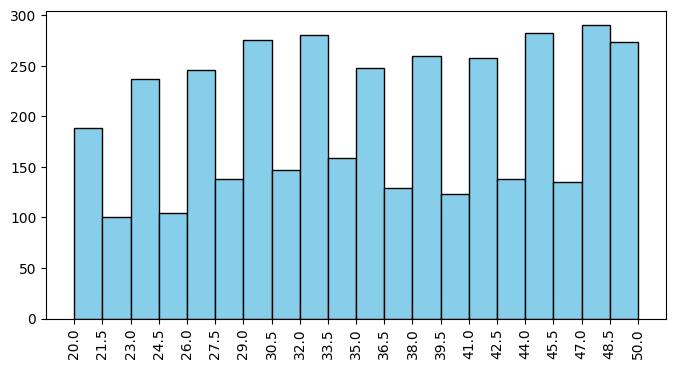

,instruction,input,output,prompt
29,Write a function in Python to calculate the su...,,def sum_digits(num):\n total = 0\n while...,Below is an instruction that describes a task....
23,Create a Python neural network model that take...,"[10, 10.4, 10.5, 10.6, 10.7, 10.9, 11]",import numpy as np\nimport tensorflow as tf\n\...,Below is an instruction that describes a task....
48,Write a Python program to generate a Markov ch...,Alice was beginning to get very tired of sitti...,import random\n\ndef generateMarkov(text):\n ...,Below is an instruction that describes a task....
22,Write a Python program to query Twitter to get...,username: @elonmusk,import tweepy\n\n# Authenticate to Twitter\nau...,Below is an instruction that describes a task....
47,Create a Python program to calculate the avera...,,nums = []\nfor i in range(5):\n nums.append...,Below is an instruction that describes a task....


In [37]:
valid_indices = [idx for idx in df_alpaca.index if idx not in set(error_indices)]
token_counts = [len(tiktoken.get_encoding('cl100k_base').encode(df_alpaca['output'][idx])) for idx in valid_indices]

filtered_idx = [(idx, cnt) for idx, cnt in zip(valid_indices, token_counts) if 20 <= cnt <= 50]

filtered_counts = [cnt for _, cnt in filtered_idx]
print(f"Total tokens: {sum(filtered_counts)}\nAvg tokens: {sum(filtered_counts) / len(filtered_counts):.2f}")

bins = min(max(filtered_counts) - min(filtered_counts) + 1, 20)
plt.figure(figsize=(8, 4))
plt.hist(filtered_counts, bins=bins, color='skyblue', edgecolor='black', align='mid')
plt.xticks(np.linspace(min(filtered_counts), max(filtered_counts), bins + 1), rotation='vertical')
plt.show()
df_alpaca_filtered = df_alpaca.iloc[filtered_counts].copy(deep=True)
len(df_alpaca_filtered)
df_alpaca_filtered.head()

In [38]:
import io
import re
import random
import tokenize
import keyword

def missing_parenthesis(code):
    import re
    lines = code.split('\n')
    modified_code = code

    for i, line in enumerate(lines):
        matches = [m.start() for m in re.finditer(r"\)", line)]
        if matches:
            for match in matches:
                temp_code = line[:match] + line[match+1:]
                temp_line = '\n'.join(lines[:i] + [temp_code] + lines[i+1:])
                if not check_syntax(temp_line):
                    modified_code = temp_line
                    return True, modified_code, i + 1

    return False, modified_code, -1

def missing_colon(code):
    import re
    lines = code.split('\n')
    modified_code = code

    for i, line in enumerate(lines):
        match = re.search(r"^\s*(def|if|else|for|while|with|try|except|finally)\b.*:$", line)
        if match:
            temp_code = line[:match.end()-1] + line[match.end():]
            if not check_syntax(temp_code):
                modified_code = '\n'.join(lines[:i] + [temp_code] + lines[i+1:])
                return True, modified_code, i + 1

    return False, modified_code, -1

def missing_quotation(code):
    import re
    lines = code.split('\n')
    modified_code = code

    for i, line in enumerate(lines):
        matches = [m.start() for m in re.finditer(r"[\'\"]", line)]
        if matches:
            for match in matches[1::2]:
                temp_code = line[:match] + line[match+1:]
                temp_line = '\n'.join(lines[:i] + [temp_code] + lines[i+1:])
                if not check_syntax(temp_line):
                    modified_code = temp_line
                    return True, modified_code, i + 1

    return False, modified_code, -1

def missing_comma(code):
    import re
    lines = code.split('\n')
    modified_code = code

    for i, line in enumerate(lines):
        matches = [m.start() for m in re.finditer(r",", line)]
        if matches:
            for match in matches:
                temp_code = line[:match] + line[match+1:]
                temp_line = '\n'.join(lines[:i] + [temp_code] + lines[i+1:])
                if not check_syntax(temp_line):
                    modified_code = temp_line
                    return True, modified_code, i + 1

    return False, modified_code, -1

def mismatched_quotation(code):
    import re
    lines = code.split('\n')
    modified_code = code

    for i, line in enumerate(lines):
        matches = [(m.start(), m.group()) for m in re.finditer(r"[\'\"]", line)]
        if matches:
            for index in range(1, len(matches), 2):
                match, char = matches[index]
                new_char = '"' if char == "'" else "'"
                temp_code = line[:match] + new_char + line[match+1:]
                temp_line = '\n'.join(lines[:i] + [temp_code] + lines[i+1:])
                if not check_syntax(temp_line):
                    modified_code = temp_line
                    return True, modified_code, i + 1

    return False, modified_code, -1

def mismatched_bracket(code):
    bracket_map = {
        ')': [']', '}'],
        ']': [')', '}'],
        '}': [')', ']']
    }

    lines = code.split('\n')
    modified_code = code

    for i, line in enumerate(lines):
        matches = [(m.start(), m.group()) for m in re.finditer(r"[)\]}]", line)]
        if matches:
            for match, bracket in matches:
                new_bracket = random.choice(bracket_map[bracket])
                temp_code = line[:match] + new_bracket + line[match+1:]
                temp_line = '\n'.join(lines[:i] + [temp_code] + lines[i+1:])
                if not check_syntax(temp_line):
                    modified_code = temp_line
                    return True, modified_code, i + 1

    return False, modified_code, -1

def extract_imported_identifiers(code):
    stream = io.BytesIO(code.encode('utf-8'))
    tokens = list(tokenize.tokenize(stream.readline))

    imported_identifiers = []
    capture = False

    for toktype, tokval, _, _, _ in tokens:
        if toktype == tokenize.NAME:
            if tokval in ['import', 'from', 'as']:
                capture = True
            elif capture:
                imported_identifiers.append(tokval)
        elif toktype == tokenize.OP and tokval == ',':
            continue
        elif toktype in [tokenize.NEWLINE, tokenize.NL, tokenize.ENDMARKER]:
            capture = False

    return imported_identifiers

def keywords_as_identifier(code):
    try:
        python_keywords = keyword.kwlist
        stream = io.BytesIO(code.encode('utf-8'))
        tokens = list(tokenize.tokenize(stream.readline))
        modified_code = code
        imported_identifiers = extract_imported_identifiers(code)

        identifiers = [(tok.start[0], tok.start[1], tok.string) for tok in tokens
                       if tok.type == tokenize.NAME and not keyword.iskeyword(tok.string) and tok.string not in imported_identifiers]

        for line, start, identifier in identifiers:
            valid_keywords = [kw for kw in python_keywords if kw != identifier]
            if valid_keywords:
                rand_keyword = random.choice(valid_keywords)
                lines = modified_code.split('\n')
                old_line = lines[line - 1]
                new_line = old_line[:start] + rand_keyword + old_line[start + len(identifier):]
                lines[line - 1] = new_line
                modified_code = '\n'.join(lines)

                if not check_syntax(modified_code):
                    return True, modified_code, line

        return False, modified_code, -1
    except Exception as e:
        print(f"Error: {e}")
        return False, code, -1

